# Adam

In [9]:
def adam(parameters, vs, sqrs, lr, t, beta1=0.9, beta2=0.999):
    eps = 1e-8
    i = 0
    for param, v, sqr in zip(parameters, vs, sqrs):
        v = beta1 * v + (1 - beta1) * param.grad.data
        sqr = beta2 * sqr + (1 - beta2) * param.grad.data ** 2
        v_hat = v / (1 - beta1 ** t)
        s_hat = sqr / (1 - beta2 ** t)
        param.data = param.data - lr * v_hat / torch.sqrt(s_hat + eps)
        vs[i] = v
        sqrs[i] = sqr
        i += 1

In [1]:
import numpy as np
import torch
from torchvision.datasets import mnist # 导入 pytorch 内置的 mnist 数据
from torch.utils.data import DataLoader
from torch import nn
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
%matplotlib inline

def data_tf(x):
    x = np.array(x, dtype='float32')
    x = (x - 0.5) / 0.5 # 标准化，这个技巧之后会讲到
    x = x.reshape((-1,)) # 拉平
    x = torch.from_numpy(x)
    return x

train_set = mnist.MNIST('./data', train=True, transform=data_tf, download=True) # 载入数据集，申明定义的数据变换
test_set = mnist.MNIST('./data', train=False, transform=data_tf, download=True)

# 定义 loss 函数
criterion = nn.CrossEntropyLoss()

In [10]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

# 初始化梯度平方项和动量项
sqrs = []
vs = []
for param in net.parameters():
    sqrs.append(torch.zeros_like(param.data))
    vs.append(torch.zeros_like(param.data))
t = 1
# 开始训练
losses = []

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        adam(net.parameters(), vs, sqrs, 1e-3, t) # 学习率设为 0.001
        t += 1
        # 记录误差
        train_loss += loss.data[0]
        losses.append(loss.data[0])
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.883135
epoch: 1, Train Loss: 0.226853
epoch: 2, Train Loss: 0.197619
epoch: 3, Train Loss: 0.210232
epoch: 4, Train Loss: 0.209438
使用时间: 58.79375 s


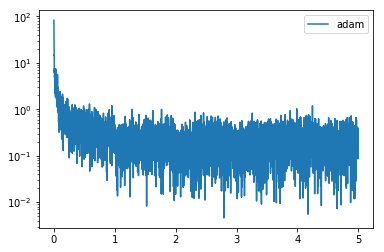

In [12]:
x_axis = np.linspace(0, 5, len(losses), endpoint=True)
plt.semilogy(x_axis, losses, label='adam')
plt.legend(loc='best')

可以看到使用 adam 算法 loss 能够更快更好地收敛

当然 pytorch 中也内置了 adam 的实现，只需要调用 `torch.optim.Adam()`，下面是例子

In [2]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    
# 开始训练
losses = []

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.data[0]
        losses.append(loss.data[0])
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 1.091973
epoch: 1, Train Loss: 0.231908
epoch: 2, Train Loss: 0.201570
epoch: 3, Train Loss: 0.194912
epoch: 4, Train Loss: 0.195840
使用时间: 50.57007 s
